### Topic clustering of claims

In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [2]:
claim_text_ank = open("Claims_ank.txt").read()
claim_text_ian = open("Claims_ian.txt").read()

In [3]:
claims_split = claim_text_ank.split("\n\n#") + claim_text_ian.split("\n\n#")

In [4]:
len(claims_split)

443

In [5]:
actor = []
claims = []
count = 0
for c in claims_split:
    txt = c.split("\n")
    act_done = False
    while not act_done:
        try:
            actor.append((txt[-1].split(' HAS')[0]).split('#ACTOR: ')[1])
            act_done = True
#             print(actor[-1])
        except:
            txt = txt[:-1]
    claims.append('.'.join(txt[1:-1]))
    count+=1

### Stopwords, stemming, and tokenizing

In [6]:
stopwords = nltk.corpus.stopwords.words('english')

In [7]:
print(stopwords[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [8]:
#  load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")


Below I define two functions:

* tokenize_and_stem: tokenizes (splits the claims into a list of its respective words (or tokens) and also stems each token

* tokenize_only: tokenizes the claims only

These functions are used to create a dictionary for using stems for an algorithm, and later convert stems back to their full words.

In [9]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [10]:
#use extend so it's a big flat list of vocab

totalvocab_stemmed = []
totalvocab_tokenized = []
for i in claims:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [11]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 7185 items in vocab_frame


In [12]:
vocab_frame.head(5)

,words
a,a
stroll,stroll
in,in
the,the
countri,country


## Tf-idf and document similarity 

In [36]:

from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.1, max_features=20000,
                                 min_df=0.01, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,6))

tfidf_matrix = tfidf_vectorizer.fit_transform(claims) #fit the vectorizer to synopses


print(tfidf_matrix.shape)

/home/users/adutta/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(443, 212)


In [37]:
terms = tfidf_vectorizer.get_feature_names()

In [38]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

## K-means clustering 

In [39]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 210 ms, sys: 257 µs, total: 210 ms
Wall time: 128 ms


In [40]:
claim_list = { 'actor': actor,'claims': claims, 'cluster': clusters }

clus = pd.DataFrame(claim_list, index = [clusters] , columns = ['actor', 'claims','cluster',])

In [41]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
# print(vocab_frame.index)
top6_cluster_features = []
count6 = 0
for i in range(num_clusters):
    print("Cluster %d claims:" % i, end='')
    top6_cluster_features.append([])
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        ii = terms[ind].split(' ')[0]
        xx = vocab_frame["words"][ii].values.tolist()[0]
        top6_cluster_features[count6].append(xx)
        print(' %s' % xx, end=',')
    count6+=1
    print() #add whitespace
    print() #add whitespace

Top terms per cluster:

Cluster 0 claims: gas, reduce, environmental, mandate, energy, years,

Cluster 1 claims: global, united, states, united, nations, united,

Cluster 2 claims: administration, approaches, bush, problem, pollution, clinton,

Cluster 3 claims: change, climate, president, .the, making, fact,

Cluster 4 claims: gases, treaty, country, greenhouse, kyoto, carbon,



In [42]:
top6_cluster_features

[['gas', 'reduce', 'environmental', 'mandate', 'energy', 'years'],
 ['global', 'united', 'states', 'united', 'nations', 'united'],
 ['administration', 'approaches', 'bush', 'problem', 'pollution', 'clinton'],
 ['change', 'climate', 'president', '.the', 'making', 'fact'],
 ['gases', 'treaty', 'country', 'greenhouse', 'kyoto', 'carbon']]

#### Save the clustered data in a pickle file 

In [47]:
import pickle
with open("clustered_claims_final1.pkl", 'wb') as f:
    ##                    max_df,min_df,ngram_range
    pickle.dump([claim_list,top6_cluster_features,0.2, 0.02,(1,6)], f)
with open("clean_actors_final1.pkl", 'wb') as f:
    pickle.dump(actor, f)    

### Multidimensional scaling¶


In [43]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=0)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#### Visualizing document clusters¶ 

In [44]:

#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#0570b3',}
#set up cluster names using a dict
cluster_names = {0: "Cluster 1",
                 1: "Cluster 2",
                 2: "Cluster 3",
                 3: "Cluster 4",
                 4: "Cluster 5"}

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


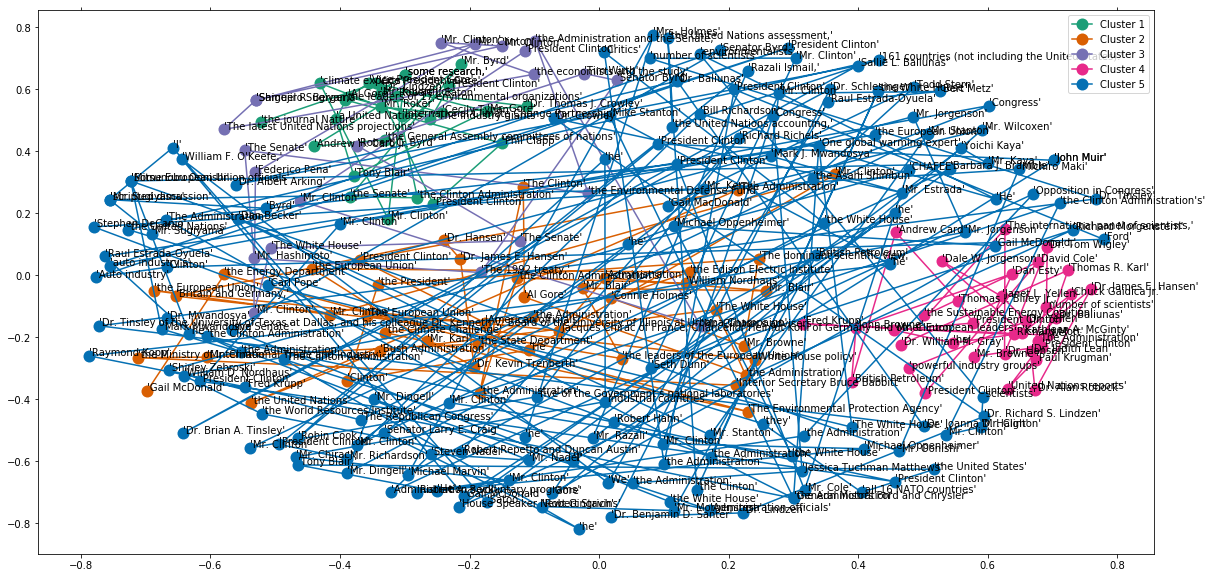

<Figure size 432x288 with 0 Axes>

In [248]:

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=actor)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(20, 10)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='-', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='on',      # ticks along the bottom edge are off
        top='on',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='on',      # ticks along the bottom edge are off
        top='on',         # ticks along the top edge are off
        labelleft='on')
    
ax.legend(numpoints=1)  #show legend with only 1 point

# print(df)
#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=10)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
plt.savefig('download.png', dpi=200)

In [45]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [46]:

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=actor)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: 0;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=20, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=15, hoffset=15, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot



/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


In [25]:
#uncomment the below to export to html
html = mpld3.fig_to_html(fig)
htmlfile = open("clustered_claims_combine_v1.html", 'w')
htmlfile.write(html)
htmlfile.close()